In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')

Mounted at /content/drive


In [2]:
#Libraries needed
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from  matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
import cv2 

# Import skimage modules
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure

In [3]:
#helper function for all metrics needed for questions

def evaluateAndGetMyMetrics(myModel,testDataset,testDatasetLabels):

  y_pred=myModel.predict_classes(testDataset)
  print("Training Metrics")
  #accuracy
  plt.figure(figsize=(15,10))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # loss
  plt.figure(figsize=(15,10))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='lower left')
  plt.show()

  print("Test Metrics")
  print("Classification Report for Test Dataset")
  print(classification_report(testDatasetLabels, y_pred))

  print("Confusion Matrix")
  matrix = metrics.confusion_matrix(testY, y_pred)

  classes=[0,1,2]
  matrix_norm = np.around(matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis], decimals=2)

  con_mat_df = pd.DataFrame(matrix_norm,
                      index = classes, 
                      columns = classes)

  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

In [4]:
#load images as numpy arrays
trainX=np.load('/content/drive/MyDrive/Colab Notebooks/trainX.npy')
valX=np.load('/content/drive/MyDrive/Colab Notebooks/valX.npy')
testX=np.load('/content/drive/MyDrive/Colab Notebooks/testX.npy')
print("train images shape",trainX.shape)
print("validation images shape",valX.shape)
print("test images shape",testX.shape)

#load class of each image {'Disappointed': 0, 'interested': 1, 'neutral': 2}
trainY=np.load('/content/drive/MyDrive/Colab Notebooks/trainY.npy')
valY=np.load('/content/drive/MyDrive/Colab Notebooks/valY.npy')
testY=np.load('/content/drive/MyDrive/Colab Notebooks/testY.npy')

print("Train Images Per Class")
print("Class 0 (Disappointed):",(trainY==0).sum())
print("Class 1 (Interested):",(trainY==1).sum())
print("Class 2 (Neutral):",(trainY==2).sum())

print("Validation Images Per Class")
print("Class 0 (Disappointed):",(valY==0).sum())
print("Class 1 (Interested):",(valY==1).sum())
print("Class 2 (Neutral):",(valY==2).sum())

print("Test Images Per Class")
print("Class 0 (Disappointed):",(testY==0).sum())
print("Class 1 (Interested):",(testY==1).sum())
print("Class 2 (Neutral):",(testY==2).sum())



train images shape (30672, 64, 64)
validation images shape (8764, 64, 64)
test images shape (4383, 64, 64)
Train Images Per Class
Class 0 (Disappointed): 8913
Class 1 (Interested): 12047
Class 2 (Neutral): 9712
Validation Images Per Class
Class 0 (Disappointed): 2547
Class 1 (Interested): 3442
Class 2 (Neutral): 2775
Test Images Per Class
Class 0 (Disappointed): 1274
Class 1 (Interested): 1721
Class 2 (Neutral): 1388


In [5]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(trainY),
                                                 trainY)
class_weight_dict = dict(enumerate(class_weights)) 
class_weight_dict

{0: 1.147088522383036, 1: 0.8486760189258736, 2: 1.0527182866556837}

<Figure size 432x288 with 0 Axes>

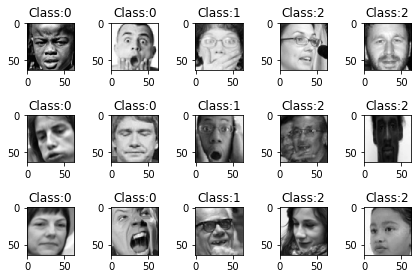

In [6]:
%matplotlib inline 
from matplotlib import pyplot as plt
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,5) 
f.tight_layout()
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
  axarr[0][i].set_title("Class:"+str(trainY[i*7000]))
  axarr[0][i].imshow(trainX[i*7000],cmap='gray')
  axarr[1][i].set_title("Class:"+str(valY[i*2000]))
  axarr[1][i].imshow(valX[i*2000],cmap='gray')
  axarr[2][i].set_title("Class:"+str(testY[i*1000]))
  axarr[2][i].imshow(testX[i*1000],cmap='gray')

In [7]:
#normalize our data


oldRange = 255 - 0
newRange = 1 - (-1)

trainX_norm = ((trainX - 0) * newRange / oldRange) + (-1)
valX_norm= ((valX - 0) * newRange / oldRange) + (-1)
testX_norm=((testX - 0) * newRange / oldRange) + (-1)

<Figure size 432x288 with 0 Axes>

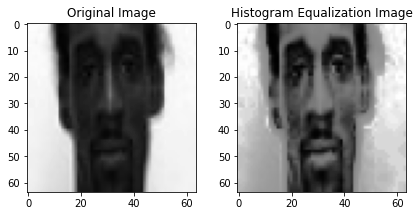

In [8]:
%matplotlib inline 



img=valX_norm[8000]
img_eq=exposure.equalize_hist(img)
plt.figure()


f, axarr = plt.subplots(1,2) 
f.tight_layout()


axarr[0].set_title("Original Image")
axarr[0].imshow(img,cmap='gray')

axarr[1].set_title("Histogram Equalization Image")
axarr[1].imshow(img_eq,cmap='gray')

In [9]:
def datasetHistogramEqualization(dataset):
  for i in range(dataset.shape[0]):
    dataset[i] = exposure.equalize_hist(dataset[i])
  return dataset


In [10]:
trainX_eq=datasetHistogramEqualization(trainX_norm)
valX_eq=datasetHistogramEqualization(valX_norm)
testX_eq=datasetHistogramEqualization(testX_norm)

<Figure size 432x288 with 0 Axes>

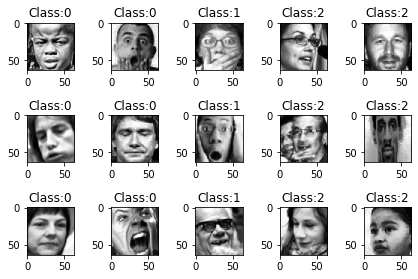

In [11]:
%matplotlib inline 
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(3,5) 
f.tight_layout()
# use the created array to output your multiple images. In this case I have stacked 4 images vertically
for i in range(5):
  axarr[0][i].set_title("Class:"+str(trainY[i*7000]))
  axarr[0][i].imshow(trainX_eq[i*7000],cmap='gray')
  axarr[1][i].set_title("Class:"+str(valY[i*2000]))
  axarr[1][i].imshow(valX_eq[i*2000],cmap='gray')
  axarr[2][i].set_title("Class:"+str(testY[i*1000]))
  axarr[2][i].imshow(testX_eq[i*1000],cmap='gray')

In [12]:
#Reshape (64,64,1)  our data

trainX_shaped = trainX_eq.reshape(trainX.shape[0],64,64,1)
valX_shaped = valX_eq.reshape(valX.shape[0],64,64,1)
testX_shaped = testX_eq.reshape(testX.shape[0],64,64,1)

In [13]:
model = models.Sequential()

model.add(layers.Conv2D(16, (3, 3), input_shape=(64,64,1),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))

model.add(layers.Conv2D(32, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))

model.add(layers.Conv2D(32, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Conv2D(64, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))

model.add(layers.Conv2D(64, (3, 3),padding='same'))
model.add(layers.BatchNormalization())
model.add(layers.Activation('swish'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))

model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(256))
model.add(layers.Activation('swish'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(128))
model.add(layers.Activation('swish'))
model.add(layers.Dropout(0.3))

#add last layer for 3 classes
model.add(layers.Dense(3))
model.add(layers.Activation('softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator and do Image Augmentation
training_datagen = ImageDataGenerator(
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')



training_images=trainX_shaped
valid_images=valX_shaped


validation_datagen = ImageDataGenerator()

training_datagen.fit(training_images)
validation_datagen.fit(valid_images)



opt = keras.optimizers.Adam(1e-3)

#to Keep best epoch waits
filepath="/content/drive/MyDrive/Colab Notebooks/weights_testAugment2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


model.compile(loss = "sparse_categorical_crossentropy",
optimizer =opt,
metrics = ["accuracy"])


history= model.fit_generator(training_datagen.flow(training_images,y = trainY,batch_size = 32), epochs=150, validation_data = validation_datagen.flow(
    valid_images,
    y = valY,
    batch_size = 32), verbose = 1,callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/150
959/959 [==============================] - 58s 26ms/step - loss: 1.4386 - accuracy: 0.3742 - val_loss: 1.0847 - val_accuracy: 0.3932

Epoch 00001: val_loss improved from inf to 1.08474, saving model to /content/drive/MyDrive/Colab Notebooks/weights_testAugment2.hdf5
Epoch 2/150
959/959 [==============================] - 25s 26ms/step - loss: 1.0922 - accuracy: 0.3936 - val_loss: 1.0867 - val_accuracy: 0.3906

Epoch 00002: val_loss did not improve from 1.08474
Epoch 3/150
959/959 [==============================] - 24s 25ms/step - loss: 1.0880 - accuracy: 0.3903 - val_loss: 1.0690 - val_accuracy: 0.4175

Epoch 00003: val_loss improved from 1.08474 to 1.06901, saving model to /content/drive/MyDrive/Colab Notebooks/weights_testAugment2.hdf5
Epoch 4/150
959/959 [==============================] - 24s 25ms/step - loss: 1.0721 - accuracy: 0.4127 - val_loss: 1.0452 - val_accuracy: 0.4487

Epoch 00004: val_loss improved from 1.06901 to 1.04517, saving model to /content/drive/MyDrive/

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Training Metrics


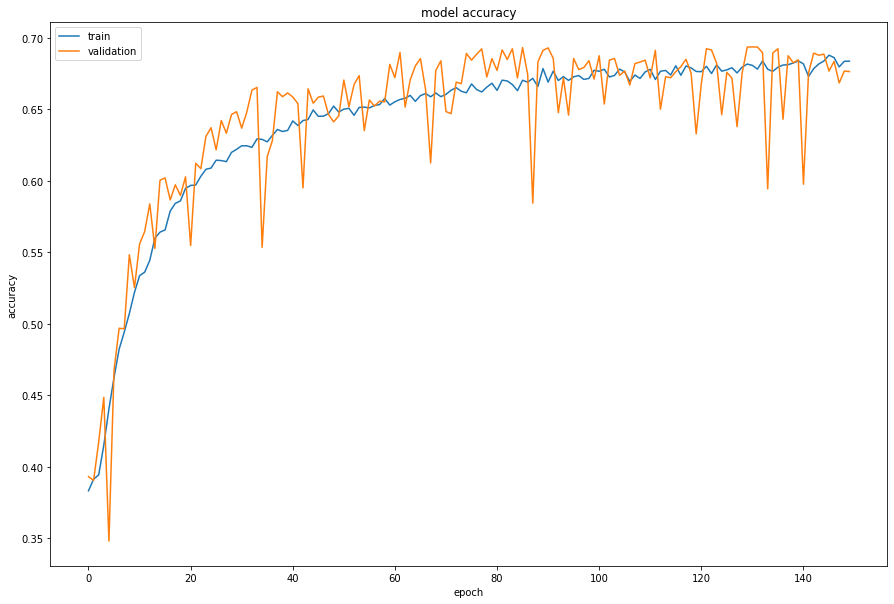

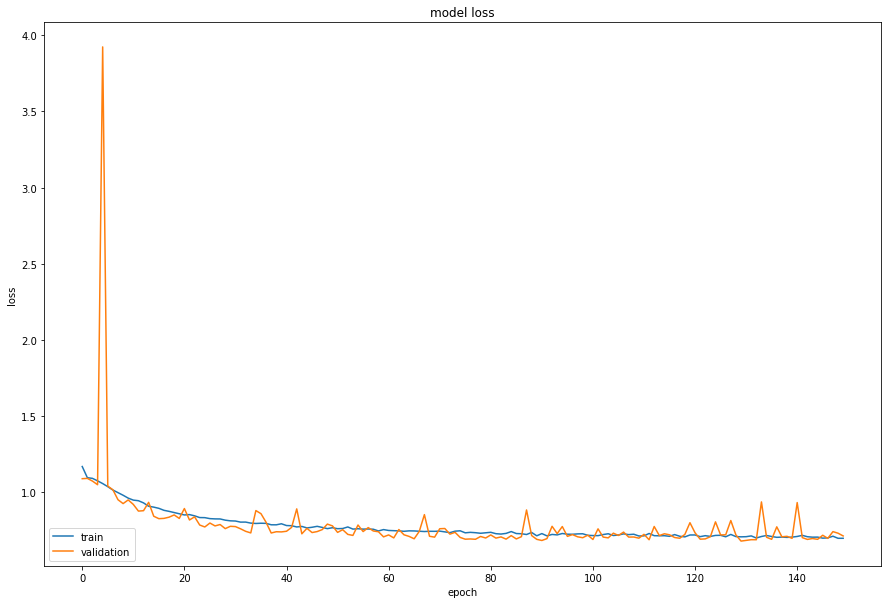

Test Metrics
Classification Report for Test Dataset
              precision    recall  f1-score   support

           0       0.68      0.40      0.50      1274
           1       0.77      0.87      0.81      1721
           2       0.59      0.72      0.64      1388

    accuracy                           0.68      4383
   macro avg       0.68      0.66      0.65      4383
weighted avg       0.69      0.68      0.67      4383

Confusion Matrix


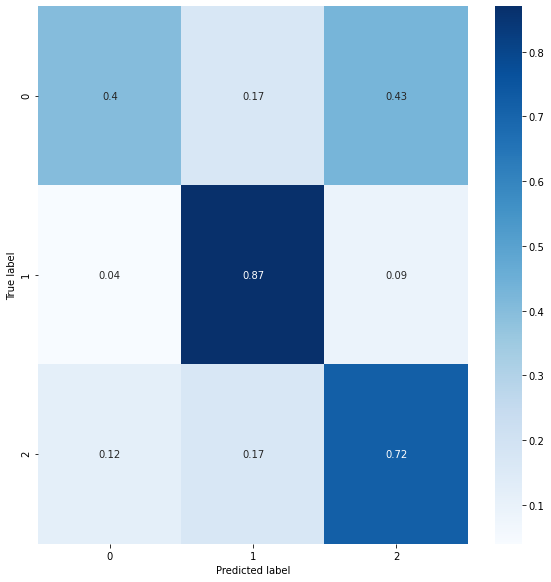

In [15]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/weights_testAugment2.hdf5")

evaluateAndGetMyMetrics(model,testX_shaped,testY)

In [20]:

filepath="/content/drive/MyDrive/Colab Notebooks/weights_testAugment_ContTest2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-5,verbose=1)
history= model.fit_generator(training_datagen.flow(training_images,y = trainY,batch_size = 32), epochs=40, validation_data = validation_datagen.flow(
    valid_images,
    y = valY,
    batch_size = 32), verbose = 1,callbacks=[checkpoint,reduce_lr])

Epoch 1/40
  3/959 [..............................] - ETA: 26s - loss: 0.5724 - accuracy: 0.7604

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


959/959 [==============================] - 24s 25ms/step - loss: 0.7090 - accuracy: 0.6822 - val_loss: 0.6846 - val_accuracy: 0.6902

Epoch 00001: val_loss improved from inf to 0.68463, saving model to /content/drive/MyDrive/Colab Notebooks/weights_testAugment_ContTest2.hdf5
Epoch 2/40
959/959 [==============================] - 24s 25ms/step - loss: 0.7124 - accuracy: 0.6783 - val_loss: 0.6837 - val_accuracy: 0.6920

Epoch 00002: val_loss improved from 0.68463 to 0.68372, saving model to /content/drive/MyDrive/Colab Notebooks/weights_testAugment_ContTest2.hdf5
Epoch 3/40
959/959 [==============================] - 24s 25ms/step - loss: 0.7094 - accuracy: 0.6790 - val_loss: 0.6648 - val_accuracy: 0.7025

Epoch 00003: val_loss improved from 0.68372 to 0.66478, saving model to /content/drive/MyDrive/Colab Notebooks/weights_testAugment_ContTest2.hdf5
Epoch 4/40
959/959 [==============================] - 24s 25ms/step - loss: 0.7089 - accuracy: 0.6814 - val_loss: 0.7043 - val_accuracy: 0.684

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Training Metrics


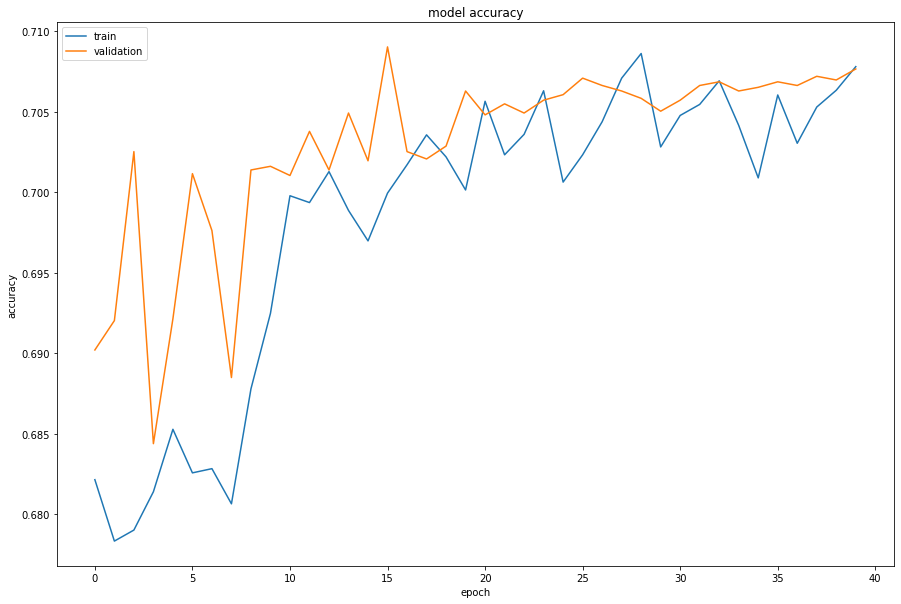

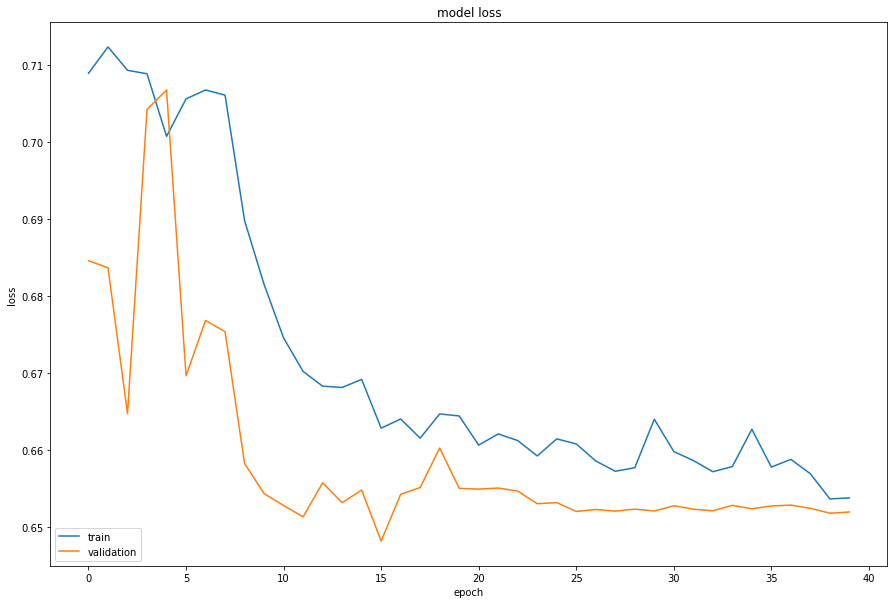

Test Metrics
Classification Report for Test Dataset
              precision    recall  f1-score   support

           0       0.69      0.45      0.54      1274
           1       0.81      0.85      0.83      1721
           2       0.60      0.74      0.66      1388

    accuracy                           0.70      4383
   macro avg       0.70      0.68      0.68      4383
weighted avg       0.71      0.70      0.69      4383

Confusion Matrix


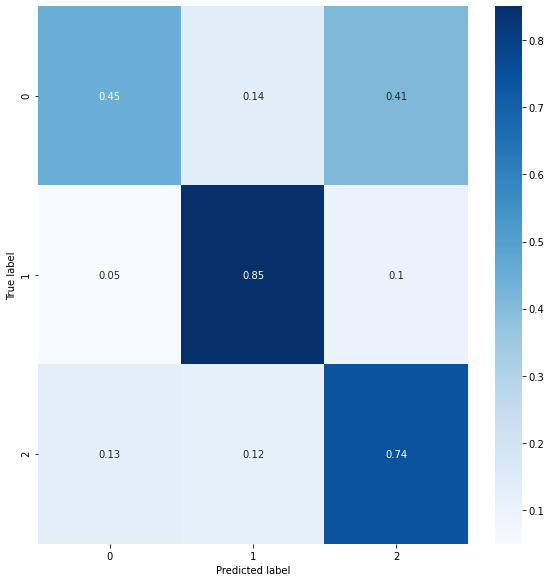

In [21]:
model.load_weights("/content/drive/MyDrive/Colab Notebooks/weights_testAugment_ContTest2.hdf5")

evaluateAndGetMyMetrics(model,testX_shaped,testY)